# SOFIA/FORCAST Galactic Center Photometry Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field49', 'Field48', 'Field45', 'Field43', 'Field11', 'Field10', 'Field04', 'Field03', 'Field02', 'Field01', 'Field05', 'Field06', 'Field42', 'Field39', 'Field41', 'Field40', 'Field38', 'Field37', 'Field33', 'Field34', 'Field32', 'Field31', 'Field29', 'Field28', 'Field25', 'Field24', 'Field20', 'Field15', 'Field17', 'Field13', 'Field12', 'Field14', 'Field16', 'Field21', 'Field18', 'Field30', 'Field36', 'Field23', 'Field19', 'Field22', 'Field26', 'Field27', 'Field07', 'Field08', 'Field09', 'Field35', 'Field44', 'Field46', 'Field47']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [2]:
#import configuration for selected file
from config import Field01 as field
from config import wavelength, bkgbox, cutsize, radii, r_in, r_out #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [3]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table, join, vstack
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, EllipticalAperture,CircularAnnulus,CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

from regions import read_ds9


In [4]:
from FORCASTphot import performApPhoto, fitshapes

## First Steps - Load data & perform background subtraction

In [5]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [6]:
#create initial background model for building source mask
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MMMBackground(sigma_clip=sigma_clip)  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg=bkg_data.background


In [7]:
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

#create masked array for the background subtracted data
data_ma = np.ma.masked_array(data, mask=maskTPS)

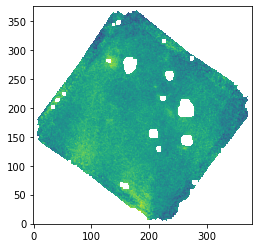

In [8]:
mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3,
                               dilate_size=3, filter_fwhm=3)

data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)

plt.imshow(data_ma2,origin='lower')
plt.show()

In [9]:
#create updated background model detected sources masked
bkg_data = Background2D(data_ma2,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg_rms=bkg_data.background_rms 
bkg=bkg_data.background

#create background subtracted image
data_bkgsub = data - bkg

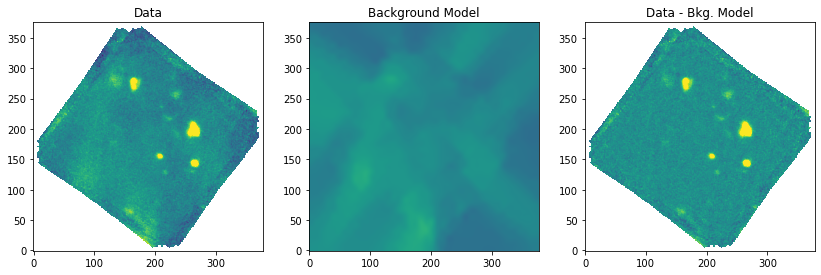

In [10]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

## Do Photometry - Combined source list

In [11]:
#load in source lists if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_CombinedSources.fits'):
    combTab=Table.read(field.name+'_'+str(wavelength)+'um_CombinedSources.fits')
else:
    combTab=None
    
#Get Source coordinates from table
if combTab is not None:
    sourcesAll=combTab['sky_centroid']

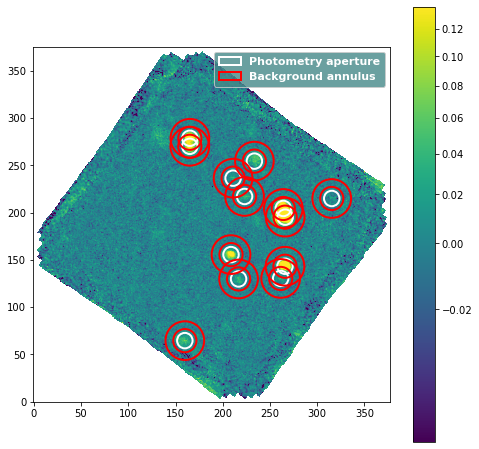

In [12]:
#radii = [4,5.5,8,10,12] #aperture radii to use in photoemtry - units are pixels
#r_in = 12  #inner radius for background annulus - units are pixels
#r_out = 20  #outer radius for background annulus - units are pixels

if combTab is not None:
    CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sourcesAll,radii,r_in,r_out,plot=True)
    
    #add additonal information to table
    CombPhotTable['Field']=field.name
    CombPhotTable['wv']=wavelength

    #display the photometry table
    #CombPhotTable
else:
    print('No sources found in Combined Source List')

In [13]:
#merge Tables
mtComb = join(combTab, CombPhotTable, keys='id')

#add shape parameters to table
mtComb=fitshapes(data_bkgsub,mtComb,cutouts=True,cutsize=cutsize) #optional plot=True for diagnostic plots

#show table - optional
mtComb

sky_centroid,finder,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.8467607412835,-28.398696354581677",210,1,216.76368763056044,129.70236646393965,"266.8467607412835,-28.398696354581677",1.5119294546086801,0.09651237363086314,2.2214676033130845,0.19304994354736352,2.114989918924273,0.28954008362660727,842.3887332020344,3.6495838639759954e-05,-4.228560030535078e-05,0.006881849904815563,210.21331787109375,209.93720872324468,1.5100079744037493,0.11983917104074045,12.600287212354031,52.64929582512713,2.2137816824933614,0.21003082618692506,10.540270315001859,210.59718330050853,2.0976965970798953,0.3106929246163332,6.751671605236224,473.8436624261443,Field01,25,6.879447278412014,5.878987757370025,5.186901915522765,2.329713727568912,2.067845084419399,-46.01161933914708,1.126638424281691,4.8314464512979445,4.872102894282564,0.727761253839881,0.008154417958096696 .. -0.0033111973465253693
"266.8348482769443,-28.395820960788406",210,2,265.8852911307868,143.17698779843028,"266.8348482769443,-28.395820960788406",23.282894135727673,0.09658583334448517,35.94486235746212,0.193138153375612,38.27686438591779,0.2896820311636674,842.3887332020344,0.00010526580688771767,0.0004500659212080679,0.008748769070191304,210.21331787109375,210.00200729716673,23.27735196512057,0.11091307791680857,209.87021911500798,52.64929582512713,35.92269367503371,0.20071094689288496,178.97725176995388,210.59718330050853,38.22698485045387,0.2948249592746428,129.65993430306455,473.8436624261443,Field01,25,6.604635454716417,6.427886028603864,4.676374909832901,2.268761856126303,1.6553269709372587,-30.37979758258099,1.3705823054654351,4.531615925370801,3.355771815155187,0.12707872856711364,0.030077134499159837 .. 0.002531893208715622
"266.8487068085537,-28.393193473177355",210,3,208.7395640446531,155.49728149042394,"266.8487068085537,-28.393193473177355",6.677373991978708,0.09483462199415295,11.392904332372261,0.18942690188585223,12.649031312681217,0.28393621743014774,842.3887332020344,-2.473156832223834e-06,-0.00014524754423786537,0.0074813077362815734,210.21331787109375,210.02961969111962,6.677504201944389,0.10990214918429388,60.75863166922191,52.64929582512713,11.393425172234988,0.19752118990332054,57.68203997663064,210.59718330050853,12.650203202372351,0.28964618070503745,43.674676364038596,473.8436624261443,Field01,25,6.399590331743004,6.368062263843359,4.667831400357108,2.1662309106824322,1.7793363821480743,-21.13405955247953,1.2174375415554004,4.494113136029068,3.3644811832027695,0.1658000835392417,0.0014714007300332273 .. 0.012250310012783702
"266.83480793113586,-28.384742484734183",110,4,266.05824405614084,195.1073248367709,"266.83480793113586,-28.384742484734183",22.92335555472092,0.09700617942109212,54.62457691687851,0.1940321529912982,75.39238494615378,0.29107507466021804,842.3887332020344,0.005044428352224508,0.008127008061718706,0.01328936828120486,210.21331787109375,209.92611066504293,22.657769954135993,0.11137086317010078,203.44432384913776,52.64929582512713,53.56223451453881,0.20157360224354495,265.7204808485981,210.59718330050853,

In [14]:
#write out catalog - May want some additional pre-processing before we get here but go ahead and print for now...
mtComb.write(field.name+'_'+str(wavelength)+'um_CombCat.fits', overwrite=True)

## Testing for shape fitting routine... Still a work in progress

In [18]:
mtComb

sky_centroid,type,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,pix2,pix2,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.83458720075186,-28.395797299573168",210,1,258.9950979257205,148.46365211574897,"266.83458720075186,-28.395797299573168",116.14355307500304,0.20529491409554337,164.65596083667992,0.28222855663095026,219.6915516803867,0.4105276418547772,245.38037792423285,0.5131894427438944,260.48136066430595,0.6158483735473554,842.3887359890834,0.025781621308118362,0.0269148189723981,0.022805798864842994,176.05335998535156,136.90909922445425,114.78616886340959,1997.316997887478,52.64929599931774,162.08965631163608,2820.5010679885936,99.54007524871008,214.26201483401297,3727.897875530294,210.59718399727095,236.89672660177385,4120.923867415743,329.05809999573574,248.26490275996503,4317.4949622320955,473.84366399385954,Field01,37,6.78053500064814,6.6117853021864725,4.62398875120489,2.2178907773249557,1.671114675918151,-24.00967002594312,4.566989896897573,3.1446738633145506,0.3019864903825546,0.031475064815592015 .. -0.00673148702323336
"266.84864706879034,-28.393211150583802",110,2,201.01914776950372,160.5903055133829,"266.84864706879034,-28.393211150583802",14.350487000753866,0.20672816295091007,20.815249057483673,0.2842173798878027,28.604877356896907,0.4133345596518862,32.54028803874509,0.516680857685461,34.98579803497458,0.6199844536605557,842.3887359890834,0.0024063857134052004,0.003581692455007962,0.016029580871546042,176.05335998535156,139.08225952960424,14.223792487040267,242.98983471599414,52.64929599931774,20.575717242493898,352.1355904077095,99.54007524871008,28.098099302042503,479.78559644904846,210.59718399727095,31.748447328035088,539.8160482138002,329.05809999573574,33.84554741155218,571.9470521433127,473.84366399385954,Field01,37,5.676917607849346,6.668895215275613,4.826259363372193,2.211209119838277,1.8739393202319659,-14.367345420631612,4.804611520749681,3.596482826817729,0.8402322405212966,0.0 .. 0.0
"266.8344668667578,-28.384736145251782",110,3,259.4980199083447,200.3127505352248,"266.8344668667578,-28.384736145251782",229.8990060056638,0.20984497538078503,373.3392446248521,0.2885131882019892,600.0939812460898,0.4195711776560438,753.0585614505296,0.5244547464364234,879.3721846607821,0.6292782390164481,842.3887359890834,0.17918044006758035,0.21929111992957634,0.1863765092988251,176.05335998535156,174.0165894812343,220.46528197925778,3797.346353193723,52.64929599931774,355.50361013742815,6141.1652378042045,99.54007524871008,562.3590851404657,9726.220177829258,210.59718399727095,694.0977862854918,12002.657565265257,329.05809999573574,794.4686684231276,13729.101430855502,473.84366399385954,Field01,37,6.265647638882555,6.570571795172241,4.813641549322402,2.251099078610677,1.8137742201250606,-38.97179122145345,4.364267189860849,3.9929567934512624,0.24474764030558901,0.0 .. 0.0
"266.84346676422666,-28.365524247184307",110,4,222.38787602888644,290.3719516251891

In [19]:
def fitshapes2(image,tab,plot=False):
    columns = ['xcentroid', 'ycentroid','fwhm' ,'semimajor_sigma','semiminor_sigma', 'orientation','covar_sigx2','covar_sigy2']
    
    #initialize table with correct column formatting by creating dummy table
    from photutils.datasets import make_4gaussians_image
    data = make_4gaussians_image()[43:79, 76:104]
    cat = data_properties(data)
    tbl = cat.to_table(columns=columns)
    tbl.remove_row(0) #remove entry from dummy table
    
    #fix keywords in table if they don't match what is expected
    if 'xcentroid' not in tab.columns:
        tab.rename_column('xcenter', 'xcentroid')
        tab.rename_column('ycenter', 'ycentroid')
    
    #loop through sources and fit shapes
    for source in tab:
        #create data cutout around source centroid position
        spos=(np.int64(source['xcentroid'])+1,np.int64(source['ycentroid'])+1)
        cutout=Cutout2D(image,spos,13,mode='partial',fill_value=0.0,copy=True)
        
        #do addtional bkg subtraciton here? - think not for now...
        mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
        c1 = cutout.data - median
        
        #get shape fitting results and store to table
        cat = data_properties(c1,background=std)
        temp = cat.to_table(columns=columns)
        tbl=vstack([tbl,temp])

        #optional plots for visual diagnostics
        if plot==True:
            position = (cat.xcentroid, cat.ycentroid)
            r = 1.0  # approximate isophotal extent
            a = cat.semimajor_sigma.value * r
            b = cat.semiminor_sigma.value * r
            theta = cat.orientation.to(u.rad).value
            apertures = EllipticalAperture(position, a, b, theta=theta)
            plt.imshow(c1, origin='lower', cmap='viridis',interpolation=None)
            apertures.plot(color='r')
            plt.show()
            
    tbl['fit_dist']=np.sqrt((tbl['xcentroid']-10.5)**2+(tbl['ycentroid']-10.5)**2)
            
    return tbl 
    
    #if needed, rename duplicate columns from seg table
    #if 'fwhm' in tab.columns:
    #    tab.rename_column('fwhm', 'fwhm_seg')
    #    print('this already has FWHM column!')
    #if 'semimajor_sigma' in tab.columns:
    #    tab.rename_column('semimajor_sigma', 'semimajor_sigma_seg')
    #if 'semiminor_sigma' in tab.columns:
    #    tab.rename_column('semiminor_sigma', 'semiminor_sigma_seg')        
    #if 'orientation' in tab.columns:
    #    tab.rename_column('orientation', 'orientation_seg')        
        
    #add fitted shape parameters to table
    #tab['fit_x_cent']=tbl['xcentroid']
    #tab['fit_y_cent']=tbl['ycentroid']        
    #tab['fwhm']=tbl['fwhm']    
    #tab['semimajor_sigma']=tbl['semimajor_sigma']
    #tab['semiminor_sigma']=tbl['semiminor_sigma']
    #tab['orientation']=tbl['orientation']

    #return input table with new columns from shape fitting
    #return tab


In [20]:
testsource=mtComb[0:2]

In [21]:
testsource

sky_centroid,type,id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]"
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,pix2,pix2,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"266.83458720075186,-28.395797299573168",210,1,258.9950979257205,148.46365211574897,"266.83458720075186,-28.395797299573168",116.14355307500304,0.20529491409554337,164.65596083667992,0.28222855663095026,219.6915516803867,0.4105276418547772,245.38037792423285,0.5131894427438944,260.48136066430595,0.6158483735473554,842.3887359890834,0.025781621308118362,0.0269148189723981,0.022805798864842994,176.05335998535156,136.90909922445425,114.78616886340959,1997.316997887478,52.64929599931774,162.08965631163608,2820.5010679885936,99.54007524871008,214.26201483401297,3727.897875530294,210.59718399727095,236.89672660177385,4120.923867415743,329.05809999573574,248.26490275996503,4317.4949622320955,473.84366399385954,Field01,37,6.78053500064814,6.6117853021864725,4.62398875120489,2.2178907773249557,1.671114675918151,-24.00967002594312,4.566989896897573,3.1446738633145506,0.3019864903825546,0.031475064815592015 .. -0.00673148702323336
"266.84864706879034,-28.393211150583802",110,2,201.01914776950372,160.5903055133829,"266.84864706879034,-28.393211150583802",14.350487000753866,0.20672816295091007,20.815249057483673,0.2842173798878027,28.604877356896907,0.4133345596518862,32.54028803874509,0.516680857685461,34.98579803497458,0.6199844536605557,842.3887359890834,0.0024063857134052004,0.003581692455007962,0.016029580871546042,176.05335998535156,139.08225952960424,14.223792487040267,242.98983471599414,52.64929599931774,20.575717242493898,352.1355904077095,99.54007524871008,28.098099302042503,479.78559644904846,210.59718399727095,31.748447328035088,539.8160482138002,329.05809999573574,33.84554741155218,571.9470521433127,473.84366399385954,Field01,37,5.676917607849346,6.668895215275613,4.826259363372193,2.211209119838277,1.8739393202319659,-14.367345420631612,4.804611520749681,3.596482826817729,0.8402322405212966,0.0 .. 0.0


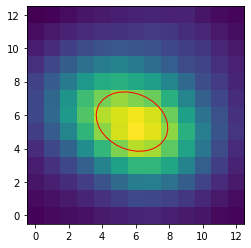

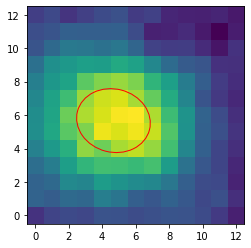

In [22]:
#newest examine
rtab=fitshapes2(data_bkgsub,testsource,plot=True)

## Other Testing For Radial Profile Plot

In [411]:
#radii=[1,2,3,4,5,6,7,8,9,10]
radii=np.linspace(0.5,10.5,20)
res=1.0

ap=CircularAperture(sc,0.5)
ap_mask=ap.to_mask(method='subpixel')
ap_arr=ap_mask.multiply(data)
ap_arr[ap_arr==0]=np.nan
cval=np.nanmax(ap_arr)


means=[cval]
meds=[cval]
stds=[cval*0.3]

for r in radii:
    an_ap = CircularAnnulus(sc, r_in=r, r_out=r+res)
    an_mask=an_ap.to_mask(method='subpixel')
    an_arr=an_mask.multiply(data)
    an_arr[an_arr==0]=np.nan
    mean,med,std=sigma_clipped_stats(an_arr)
    means.append(mean)
    #means.append(np.nanmean(an_arr))
    #meds.append(np.nanmedian(an_arr))
    #stds.append(np.nanstd(an_arr))
    
#radii.insert(0,0)
radii=np.insert(radii,0,0)

In [412]:
ap_arr

array([[0.048811  ,        nan],
       [0.31896277, 0.16200717]])

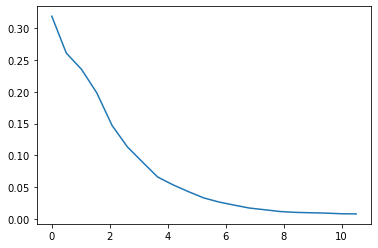

In [413]:
#plt.errorbar(radii,means,stds)
plt.plot(radii,means)

In [349]:
means

[0.1331363534927368,
 0.03674752689324892,
 0.05037123570839564,
 0.0228056921179478,
 0.022570049193288606,
 0.020759969615730747,
 0.01973311081994325,
 0.015932301123474917,
 0.013853244989548087,
 0.01562212677634492,
 0.013653672469158964,
 0.014892710750472955,
 0.012582151379487285,
 0.014387333572133263,
 0.01202212332822811,
 0.013684460654309612,
 0.012967307754653563,
 0.016721448279634312,
 0.013841269029544138,
 0.01431693605035544,
 0.01340654092684256]

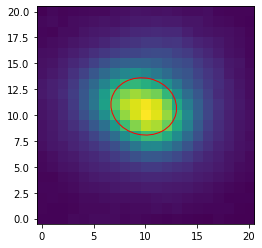

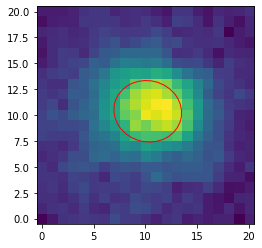

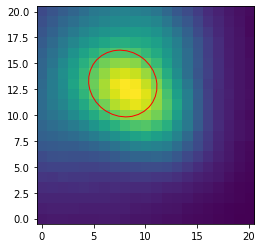

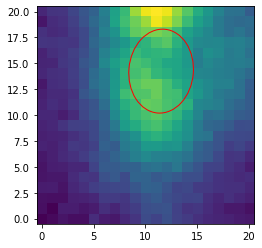

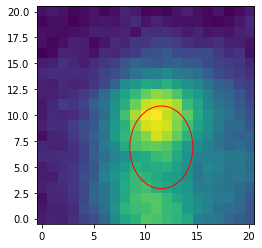

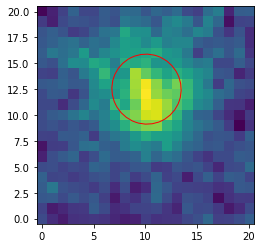

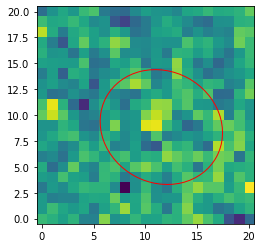

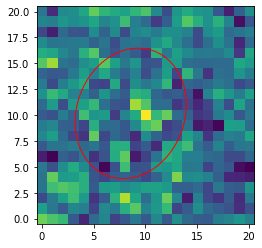

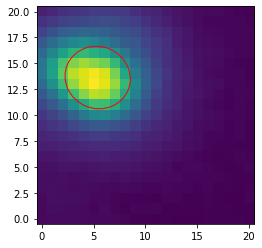

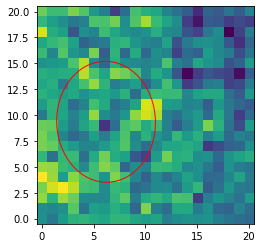

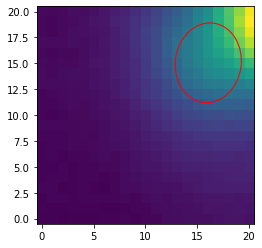

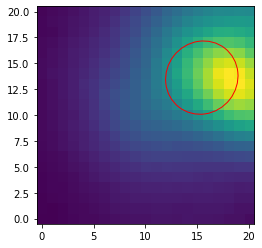

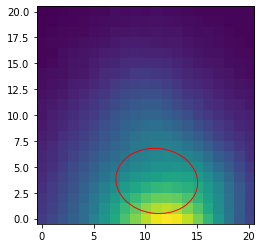

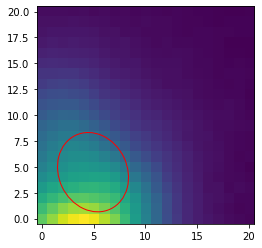

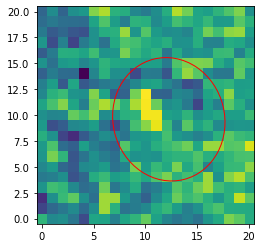

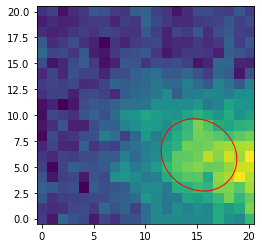

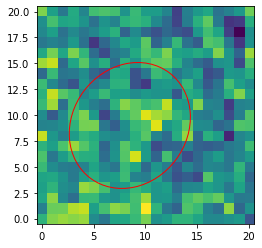

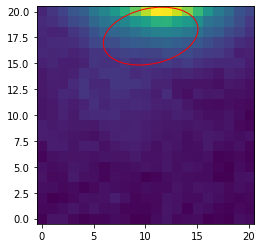

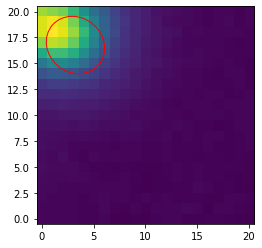

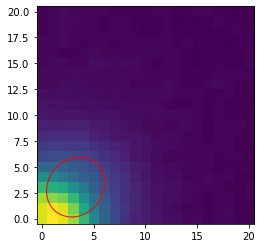

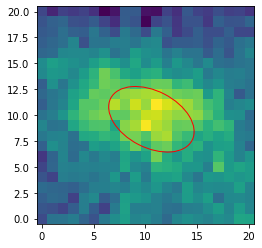

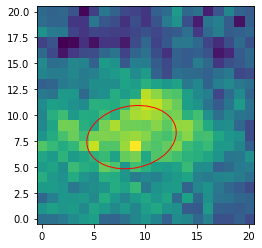

In [112]:
#bkg sub with cutout 17x17
rtab=fitshapes2(data_bkgsub,testsource,plot=True)

In [113]:
rtab

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist
,,pix,pix,pix,deg,pix2,pix2,
float64,float64,float64,float64,float64,float64,float64,float64,float64
9.84713216075264,10.835607156086768,7.005073302429263,3.191340250246159,2.741165489369058,-12.893111858464971,10.051684745492878,7.646956087456245,0.7340766845092992
10.235966511851966,10.366026787011686,7.352691179045486,3.2865975238425595,2.949075433712146,-13.682016888519996,10.683970889945263,8.81479830750726,0.29607854475127027
7.826728202560189,13.048492942849961,7.674265644547854,3.401109092072714,3.1103222923390406,-37.229665739236935,10.874471074088811,10.367176744312053,3.6933992991204097
11.526121212330365,14.245085536243648,8.519822694519807,4.059775839864416,3.114254801243581,85.10373054776521,9.747998370220452,16.432364466795075,3.883116070397035
11.54848724167043,6.885373721916732,8.363351795173493,3.993865658429673,3.0457509535800718,89.86834527246499,9.276634111305171,15.95092765751263,3.763621743235598
10.117075708073447,12.505351795989545,7.9128408515868625,3.388451565251085,3.3318583847421435,-64.05113527694374,11.174099535001824,11.408784771027229,2.0415843942942815
11.548941449309558,8.843975652152977,13.492989702434443,6.055320591286705,5.384945258955222,-28.52013005672726,34.91850360456761,30.746039300637484,1.9602792670284996
8.591256840309274,10.165093396201407,13.781276287234661,6.4293335560780065,5.211920986869369,69.91481551202773,28.83552182115215,39.664928527527906,1.9379016700890797


In [114]:
np.median(rtab['ycentroid'])

9.87958600021916

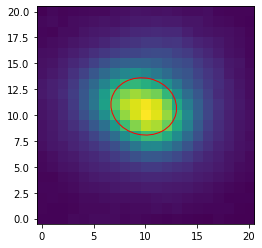

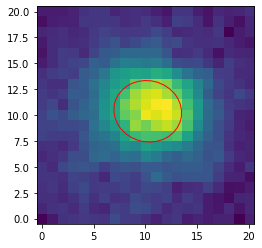

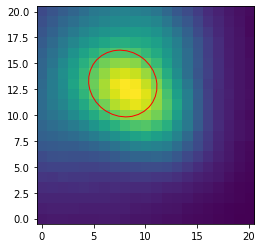

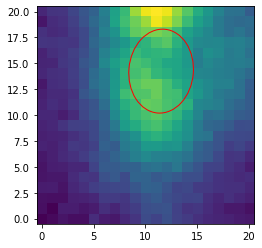

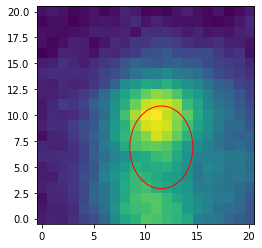

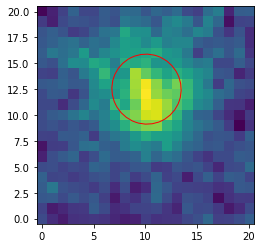

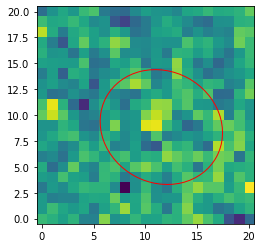

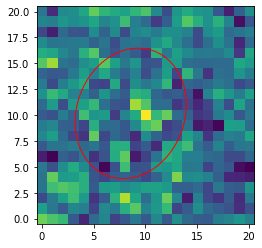

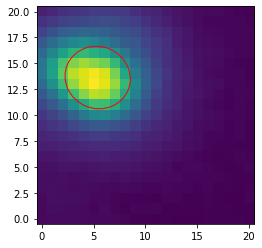

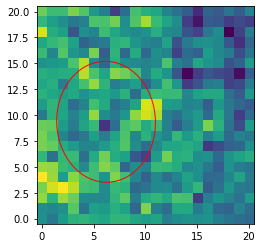

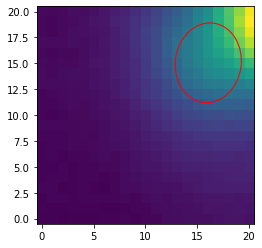

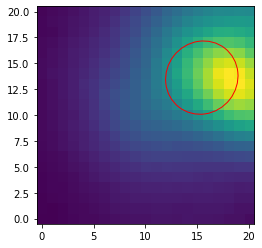

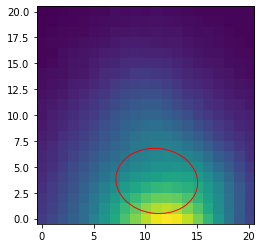

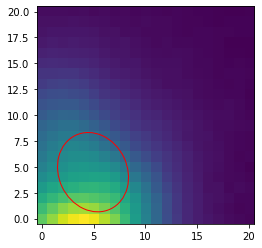

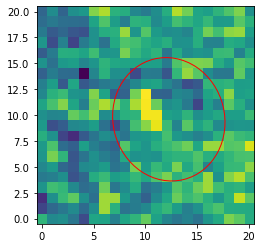

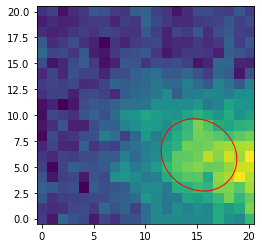

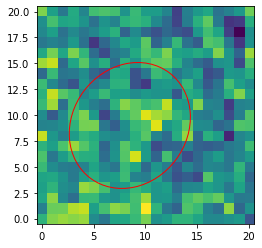

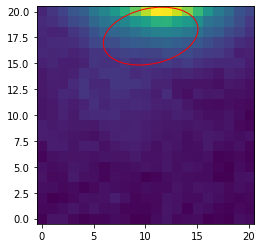

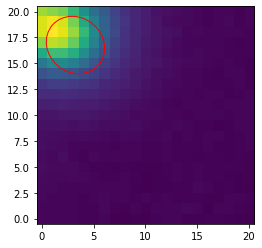

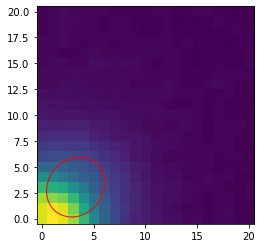

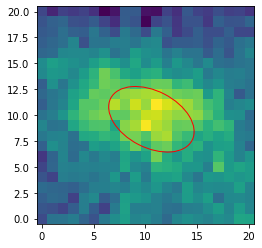

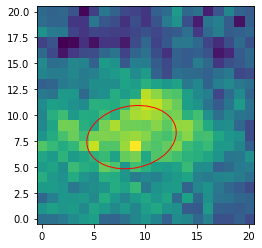

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation,covar_sigx2,covar_sigy2,fit_dist
,,pix,pix,pix,deg,pix2,pix2,
float64,float64,float64,float64,float64,float64,float64,float64,float64
9.84713216075264,10.835607156086768,7.005073302429263,3.191340250246159,2.741165489369058,-12.893111858464971,10.051684745492878,7.646956087456245,0.7340766845092992
10.235966511851966,10.366026787011686,7.352691179045486,3.2865975238425595,2.949075433712146,-13.682016888519996,10.683970889945263,8.81479830750726,0.29607854475127027
7.826728202560189,13.048492942849961,7.674265644547854,3.401109092072714,3.1103222923390406,-37.229665739236935,10.874471074088811,10.367176744312053,3.6933992991204097
11.526121212330365,14.245085536243648,8.519822694519807,4.059775839864416,3.114254801243581,85.10373054776521,9.747998370220452,16.432364466795075,3.883116070397035
11.54848724167043,6.885373721916732,8.363351795173493,3.993865658429673,3.0457509535800718,89.86834527246499,9.276634111305171,15.95092765751263,3.763621743235598
10.117075708073447,12.505351795989545,7.9128408515868625,3.388451565251085,3.3318583847421435,-64.05113527694374,11.174099535001824,11.408784771027229,2.0415843942942815
11.548941449309558,8.843975652152977,13.492989702434443,6.055320591286705,5.384945258955222,-28.52013005672726,34.91850360456761,30.746039300637484,1.9602792670284996
8.591256840309274,10.165093396201407,13.781276287234661,6.4293335560780065,5.211920986869369,69.91481551202773,28.83552182115215,39.664928527527906,1.9379016700890797


In [115]:
#bkg sub with cutout 13x13
fitshapes2(data_bkgsub,testsource,plot=True)

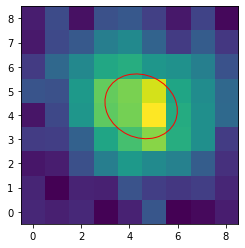

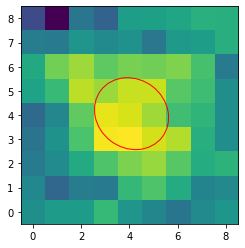

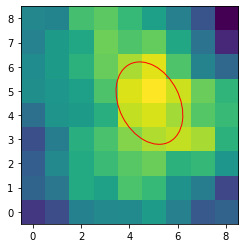

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,pix,pix,pix,deg
float64,float64,float64,float64,float64,float64
4.490483010669817,4.362329484005431,3.347642081156051,1.540947531100895,1.2912962639928434,-25.200267749430008
4.093481732508456,4.0586688592696945,3.5579666039398696,1.595826160606568,1.4209692356347339,-37.438595008044224
4.833763604371667,4.495415995003617,3.655082523020338,1.8043846200281632,1.250065397943882,-63.062605119559045


In [33]:
#bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

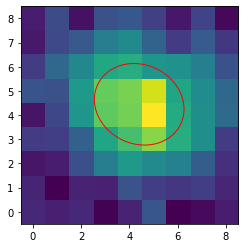

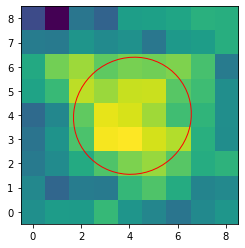

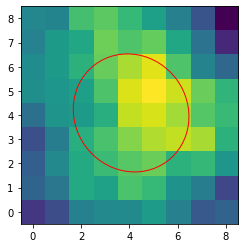

xcentroid,ycentroid,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,pix,pix,pix,deg
float64,float64,float64,float64,float64,float64
4.410352724150449,4.446561292209267,4.176804166152969,1.9029743703510267,1.6342864666483385,-25.615003890609806
4.128576719435332,3.9719936363713053,5.723627870826212,2.472983490583185,2.3874661767073775,40.273848564947166
4.074458240595917,4.089426855138581,5.694939480095021,2.4959693935184544,2.3382962279865565,-53.991394674835945


In [29]:
#no bkg sub with cutout 9x9
fitshapes2(data_bkgsub,testsource,plot=True)

## Do Photometry - Only Segment Map Sources (optional)

In [26]:
#get seg table from detection step
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None

#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']

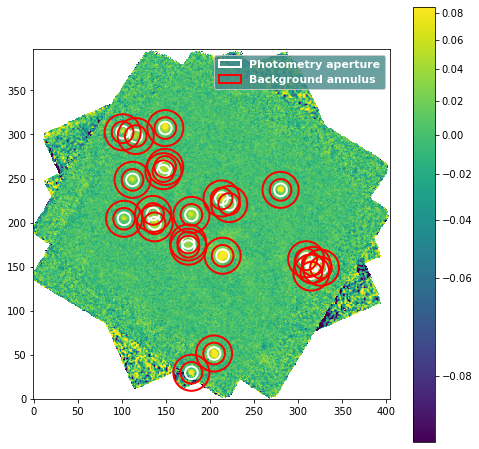

In [27]:
if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    #SegPhotTable
else:
    print('No sources found in segmentation map')

In [28]:
#fix id keywords in Seg table so they can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [37]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')

#add shape parameters to table
mtSeg=fitshapes(data_bkgsub,mtSeg) #optional plot=True for diagnostic plots

#display seg table
mtSeg

this already has FWHM column!


id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64
1,178.74334802094756,29.695390117681253,"266.05340503129935,-29.44909486681929",-0.0013619890502151399,0.0013071731744726189,0.03398650253628809,26.0,1.443840374948312,1.2160638049846695,-32.16204489596808,0.5353791657721712,0.17712248538784145,0.6205307607012144,0.5390987666544573,0.15775744598622732,1.1873064299997926,3.1432597199337975,3.368134646550717,1.3656426555364503,1.1141335679763515,2.60928748919837,1.0574602442740115,0.0011001415188336455,0.0012389231085403714,0.0007102264825112266,2.5155369672504873,178.74334802094324,29.69539011770604,"266.05340503129935,-29.44909486681929",3.620989050815081,1.539508711604046,3.6098120030926006,3.0545273225226515,-1.7956097771389976,5.919878166251133,842.3892863976475,-0.0030094404963086118,-0.005956806472558656,0.021536970474176933,105.13515000000002,73.33971114438987,3.77943407782393,46.89501562371681,52.64933039985298,4.095049898307202,37.783501424863985,161.23857434954976,-0.36960453405935056,-0.21076114147937242,473.84397359867694,FieldN9,37,4.584377197712468,4.5554895815225835,4.535910080105189,2.1362692003895267,1.6902748479416019,-46.94462228691341
2,204.44622686243497,51.53185474997358,"266.0471081083462,-29.444436612944074",-0.0052847919589830376,0.012450626299788126,1.494075155974575,120.0,3.1353880809381875,2.349310254754962,-65.50082657484333,0.16751964271530206,0.059968599526799615,0.11538669662317141,0.6622437111306206,0.25071149276934523,1.3345994104406678,6.523726466854521,13.38069941948893,3.5782239562439466,1.7587153855765443,8.86639773491292,1.8218148444296434,0.012449561647210188,0.013218304604890495,0.0026643376472243047,6.058771644800698,204.44622686241246,51.53185475002854,"266.0471081083462,-29.444436612944074",5.505680573630593,1.2118995257964638,9.929218262368778,2.118321283515523,13.15582883156841,3.6948254072154443,842.3892863976475,-0.0005571220182018139,-0.000996490121957799,0.00975187290097469,210.27030000000008,213.10771617345213,5.535012674839932,92.99084341525621,52.64933039985298,10.019047822322381,168.8111285252257,161.23857434954976,13.419817742452473,220.36449439307384,473.84397359867694,FieldN9,37,4.333721141079679,4.044061445066242,5.370293165155285,2.360878004902144,2.1972946657820014,-55.63881600516043
3,325.7005678316298,148.87073032795735,"266.0174095719637,-29.42366789441942",-0.0001871980188086556,0.027533291104583607,0.16519974662750164,6.0,1.2245560636068737,0.355653600083195,28.25368226487449,2.28900713278205,-6.036949041419875,6.283660728191581,0.9568948072663164,0.7095652778561778,3.443114489268276,2.123276765411838,3.2407826054277624,1.849319086588444,3.648138275231959,0.2842096

In [30]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)

## Do Photometry - Only DAO Sources (optional)

In [31]:
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']

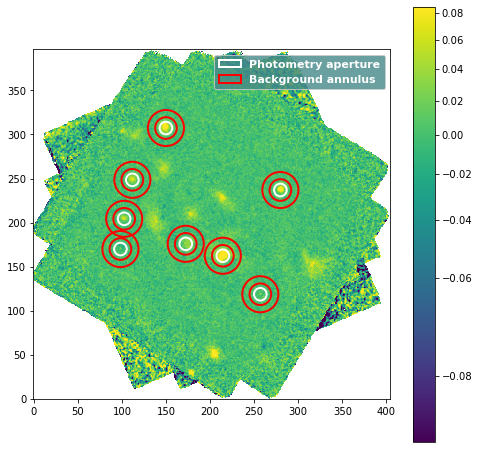

In [32]:
if daoTab is not None:
    DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

    #display the photometry table
    #DaoPhotTable
else:
    print('No sources found by DAOfind map')

In [33]:
#merge Tables
mtDao = join(daoTab, DaoPhotTable, keys='id')

#add shape parameters to table
mtDao=fitshapes(data_bkgsub,mtDao) #optional plot=True for diagnostic plots

#optional - show Dao table
#mtDao

In [34]:
#write out the resulting tables to file
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)